In [187]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import missingno as msno
import geopandas as gpd
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import warnings
from datetime import timedelta
from utils import *
import os
%config InlineBackend.figure_format='retina'
warnings.filterwarnings('ignore')

In [342]:
folder_name = '../Inputs/'
file_name = 'dataset_SCL.csv'
df = pd.read_csv(folder_name + file_name)

## Exploratory Data Analysis

In [343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


In [344]:
# Convert to datetime
df['Fecha-I'] = pd.to_datetime(df['Fecha-I']) 
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])

In [345]:
df.dtypes

Fecha-I      datetime64[ns]
Vlo-I                object
Ori-I                object
Des-I                object
Emp-I                object
Fecha-O      datetime64[ns]
Vlo-O                object
Ori-O                object
Des-O                object
Emp-O                object
DIA                   int64
MES                   int64
AÑO                   int64
DIANOM               object
TIPOVUELO            object
OPERA                object
SIGLAORI             object
SIGLADES             object
dtype: object

- Fecha-I: Scheduled date and time of the flight.
- Vlo-I : Scheduled flight number.
- Ori-I : Programmed origin city code.
- Des-I : Programmed destination city code.
- Emp-I : Scheduled flight airline code.
- Fecha-O : Date and time of flight operation.
- Vlo-O : Flight operation number of the flight.
- Ori-O : Operation origin city code
- Des-O : Operation destination city code.
- Emp-O : Airline code of the operated flight.
- DIA: Day of the month of flight operation.
- MES : Number of the month of operation of the flight.
- AÑO : Year of flight operation.
- DIANOM : Day of the week of flight operation.
- TIPOVUELO : Type of flight, I =International, N =National.
- OPERA : Name of the airline that operates.
- SIGLAORI: Name city of origin.
- SIGLADES: Destination city name.

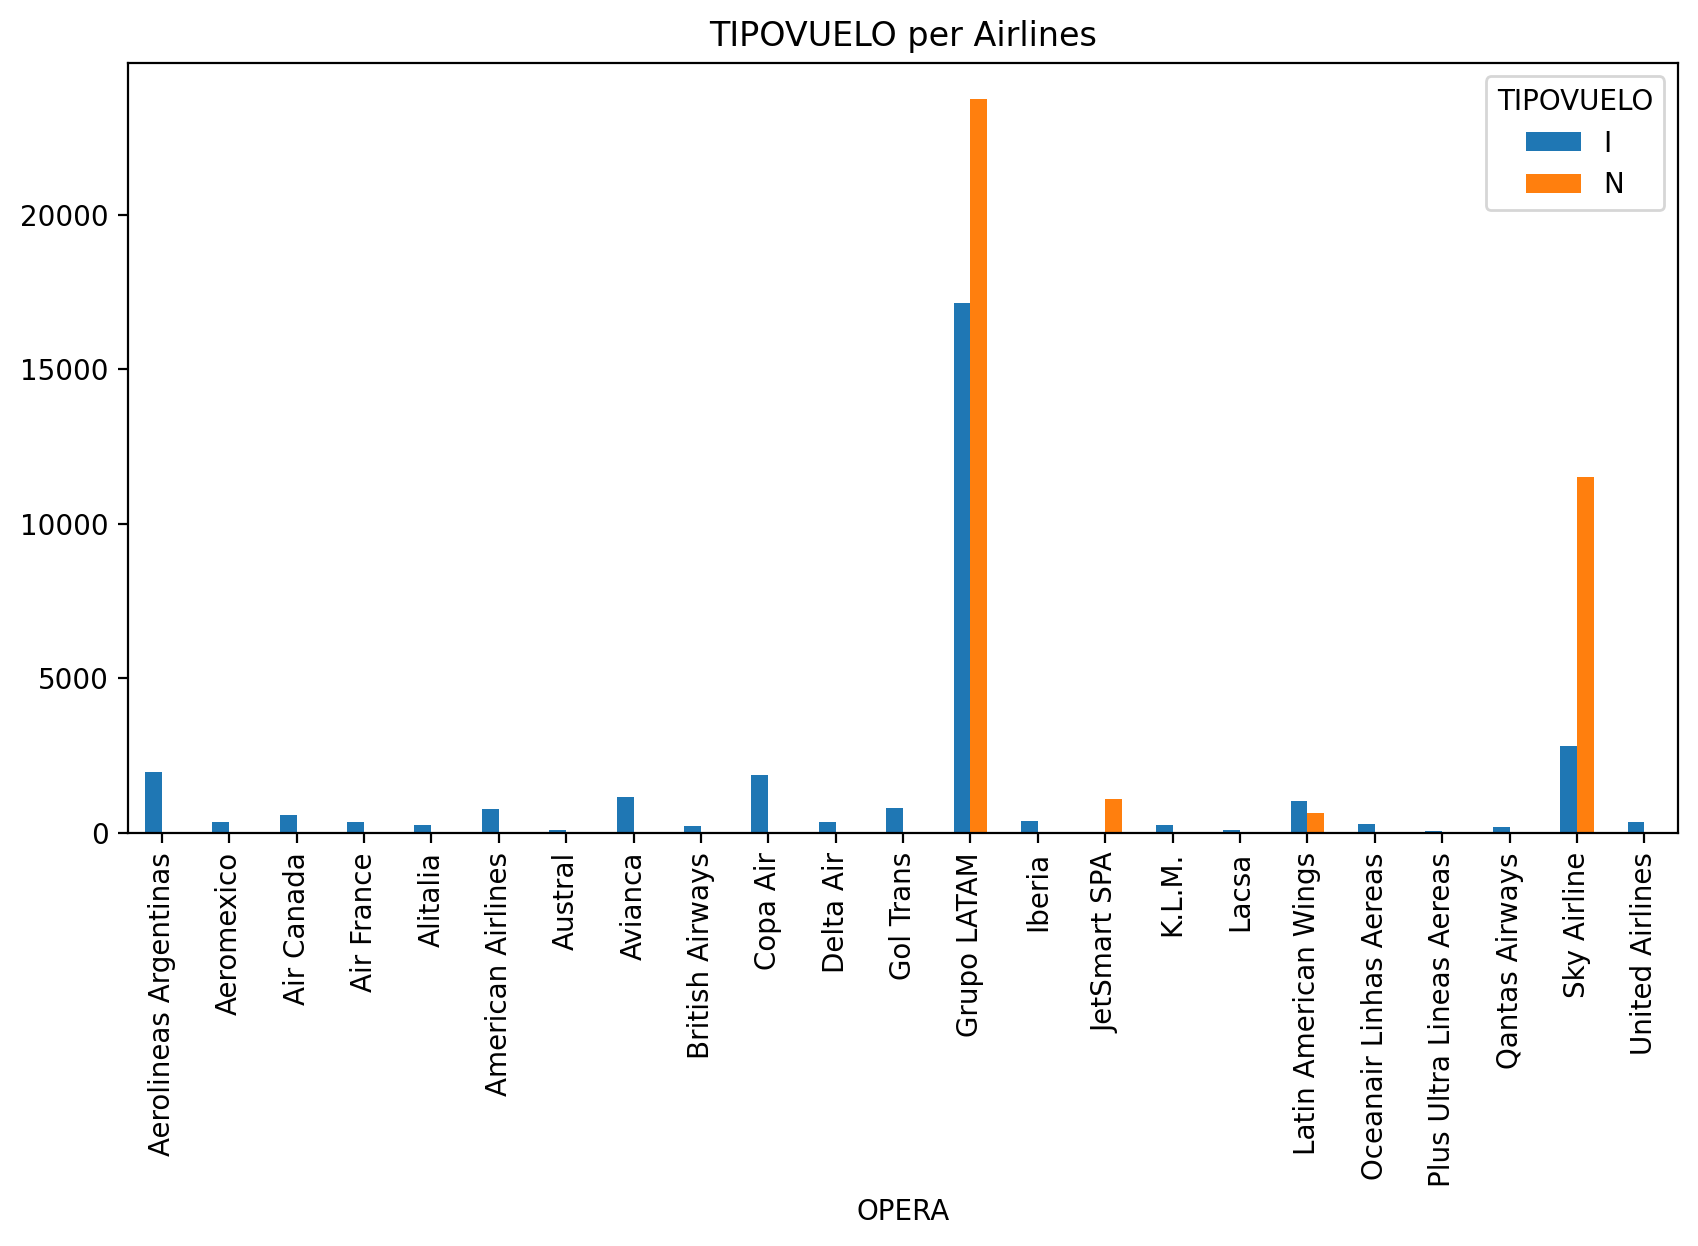

In [346]:
df.groupby(['OPERA','TIPOVUELO']).size().unstack().plot(kind='bar', stacked=False, figsize=(10,5)).set_title('TIPOVUELO per Airlines');

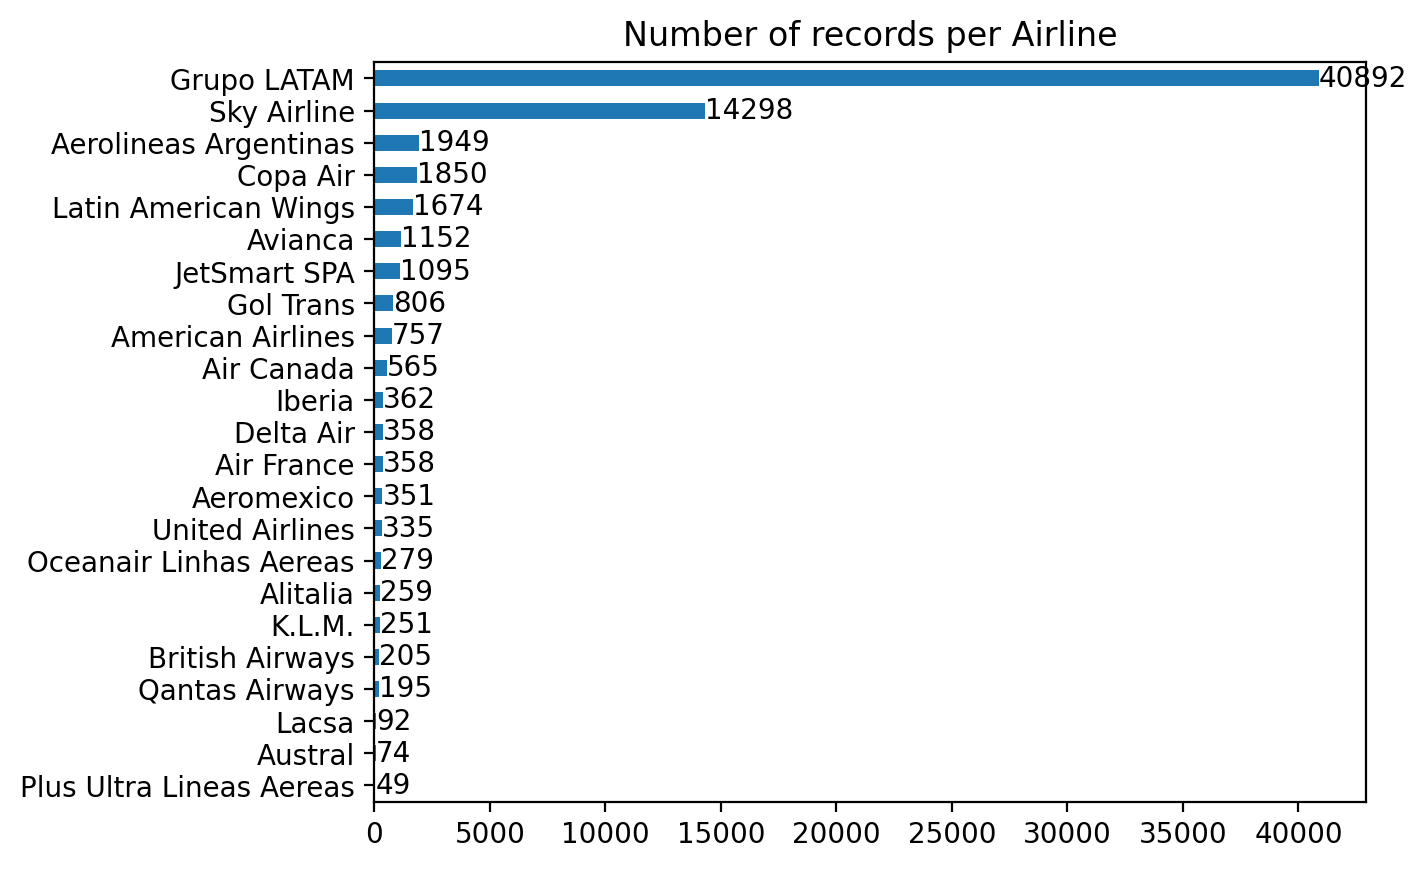

In [347]:
ax = df.OPERA.value_counts(ascending=True).plot.barh()
ax.set_title('Number of records per Airline')
ax.bar_label(ax.containers[0]);

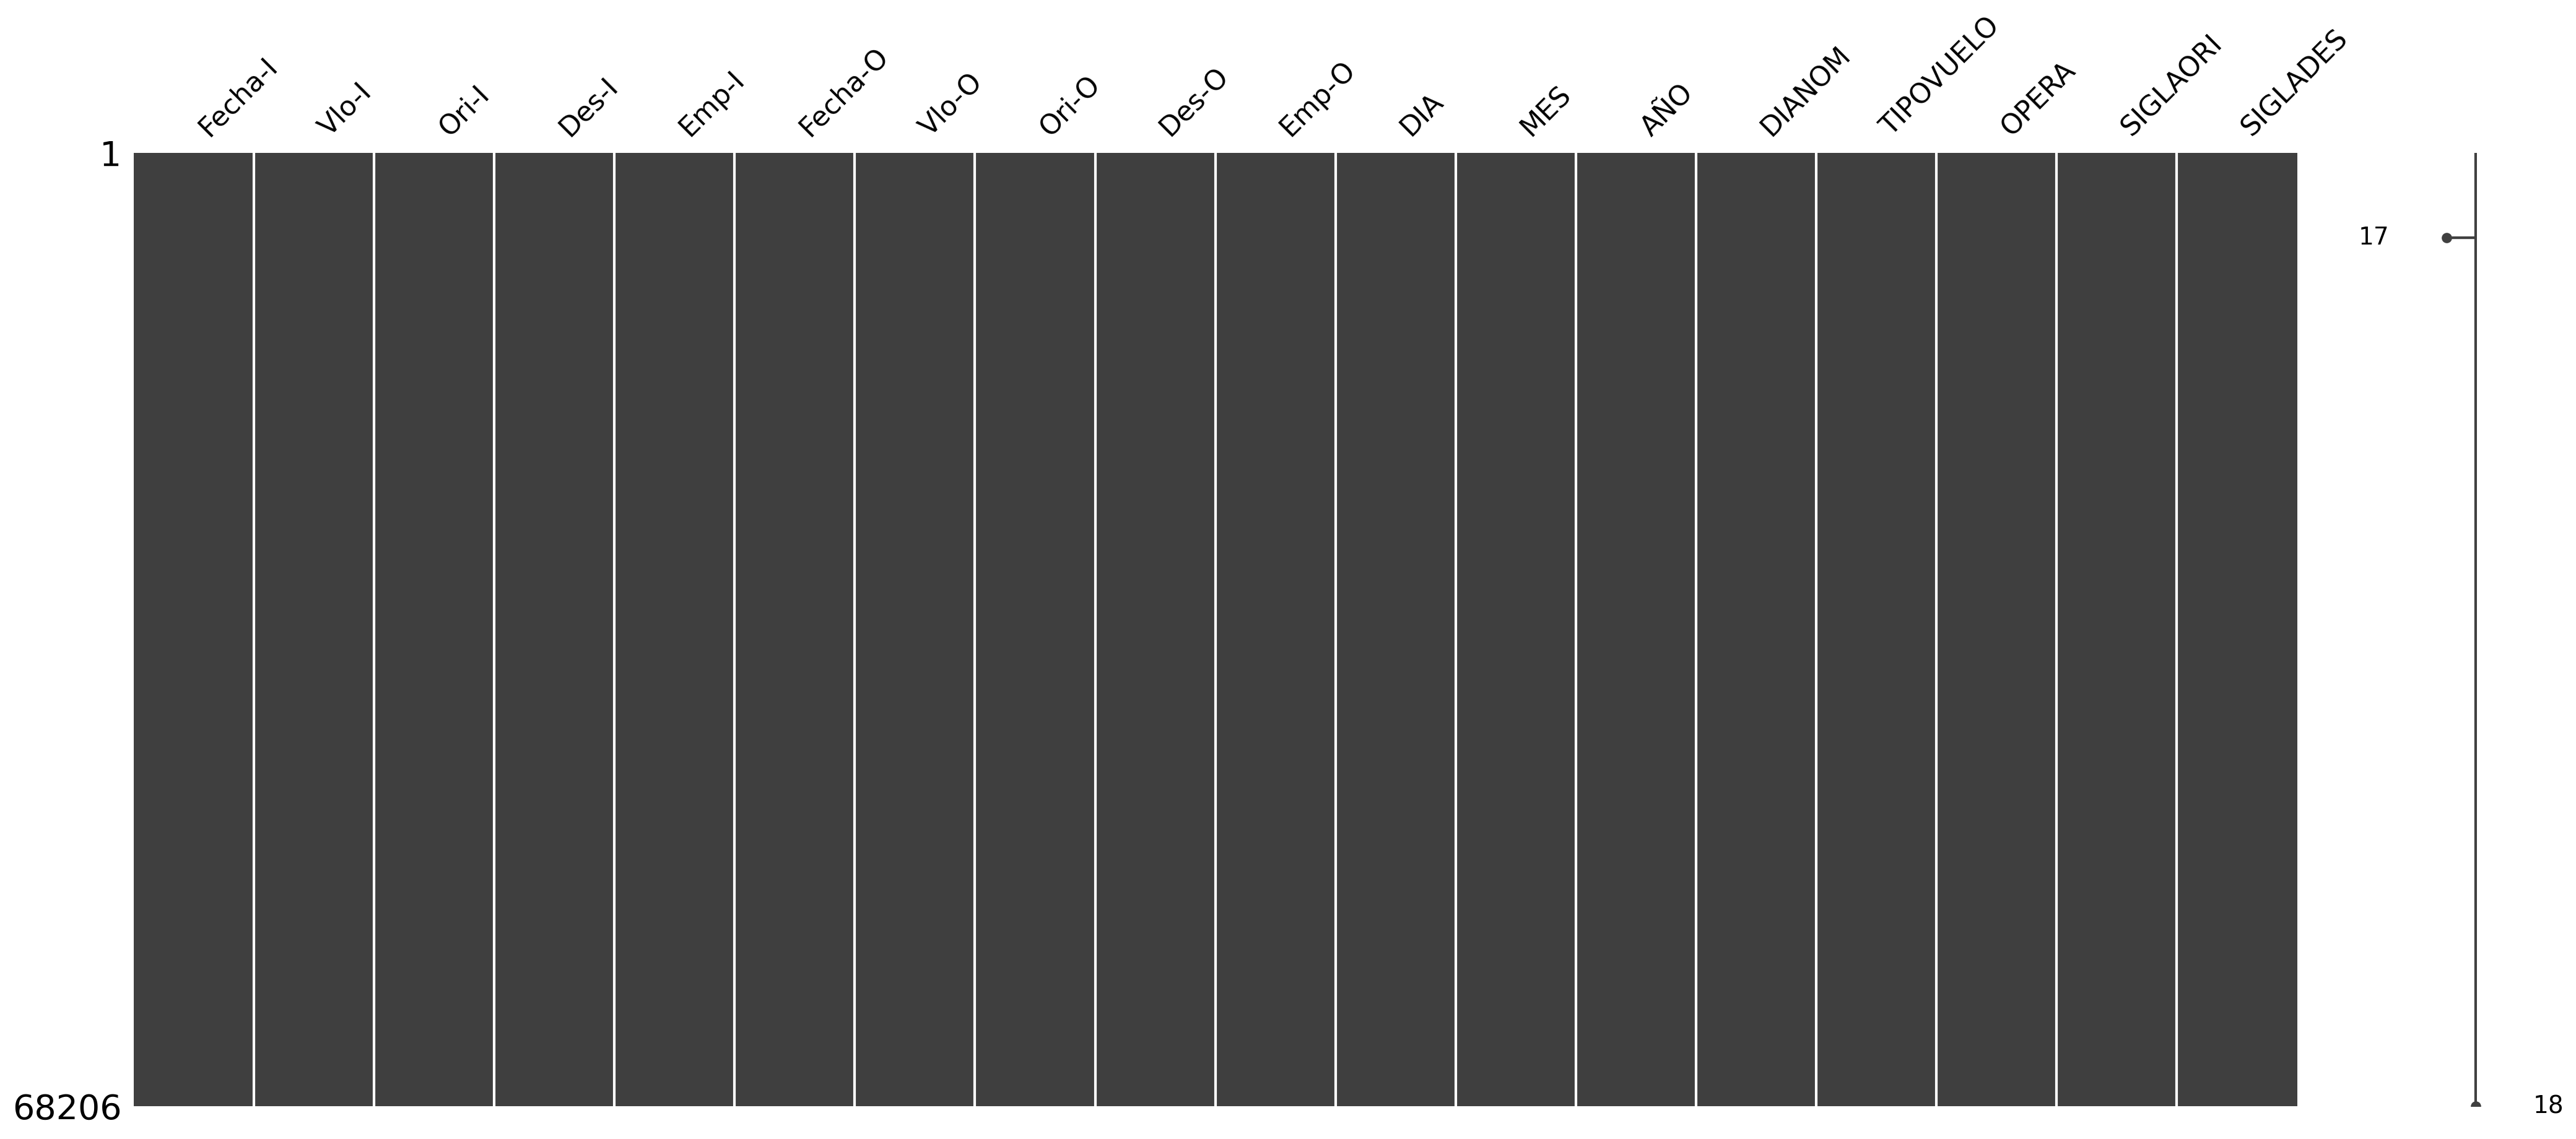

In [348]:
msno.matrix(df);

<Axes: >

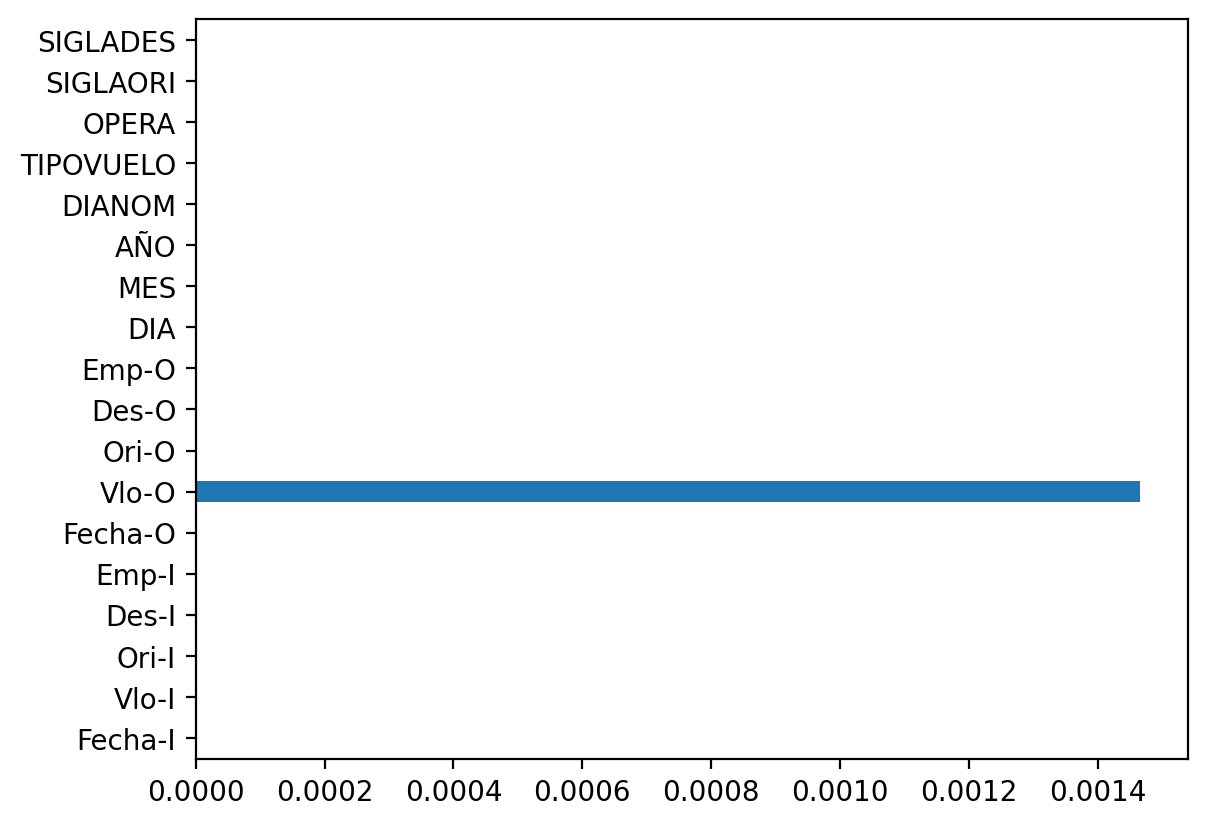

In [349]:
(df.isnull().sum()/df.shape[0]*100).plot.barh()

In [350]:
row_null_index = df['Vlo-O'][df['Vlo-O'].isnull()].index # Get index of null values
df.loc[row_null_index]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


Se aprecia un solo valor nulo para la columna 'Vlo-O', utilizar metodologías de imputación o buscar correlación entre columnas para determinar dato faltante.

In [351]:
df.groupby(["Ori-I",'SIGLAORI']).size()

Ori-I  SIGLAORI
SCEL   Santiago    68206
dtype: int64

In [352]:
df.groupby(["Des-I",'SIGLADES']).size()

Des-I  SIGLADES      
CYYZ   Toronto            283
EGLL   Londres            205
EGYP   Puerto Stanley       1
KATL   Atlanta            358
KDFW   Dallas             357
                         ... 
SULS   Punta del Este       6
SUMU   Montevideo        1066
YMML   Melbourne           38
YSSY   Melbourne            1
       Sydney             194
Length: 76, dtype: int64

The origin of all registered flights is Chile, so a good feature is the local weather.

Getting weather data from meteostat at airport of Santiago

In [37]:
from meteostat import Point, Daily,Hourly
from datetime import datetime
# Set time period
start = datetime(2017, 1, 1)
end = datetime(2017, 12, 31)

# Create Point for Vancouver, BC
santiago = Point(-33.40120502046634, -70.79999384307274, 520) # that cordenate correspond to the airport of Santiago

# Get data for 2017
data = Hourly(santiago, start, end)
data = data.fetch()

data_daily = Daily(santiago, start, end)
data_daily = data_daily.fetch()

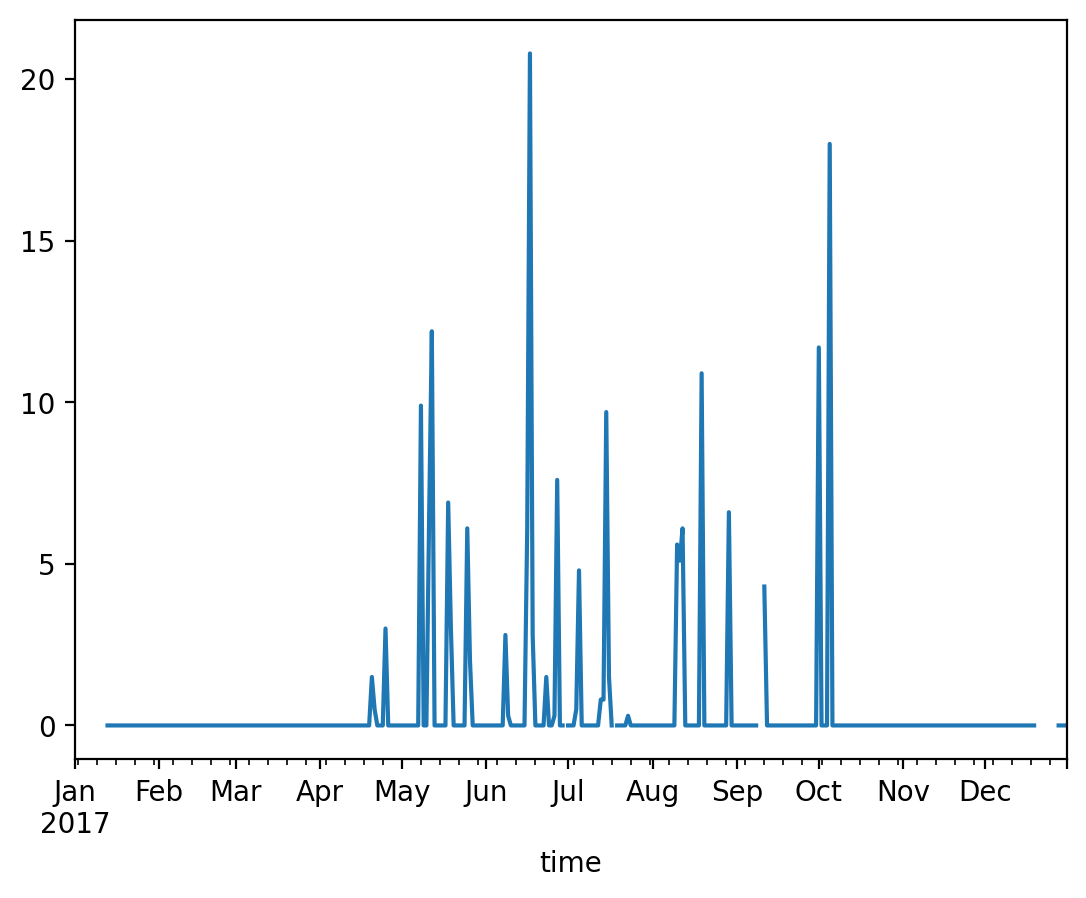

In [192]:
data_daily.prcp.plot();

In [353]:
dict_columns = {
    'time': 'Timestamp of the observation',
    'temp': 'Temperature in degrees Celsius',
    'dwpt': 'Dew point temperature in degrees Celsius',
    'rhum': 'Relative humidity as a percentage',
    'prcp': 'Precipitation in millimeters',
    'snow': 'Snowfall in centimeters',
    'wspd': 'Wind speed in kilometers per hour',
    'wdir': 'Wind direction in degrees',
    'hindex': 'Heat index in degrees Celsius',
    'coco': 'Cloud cover as a percentage',
    'vis': 'Visibility in kilometers',
    'slp': 'Sea level pressure in hPa'
}


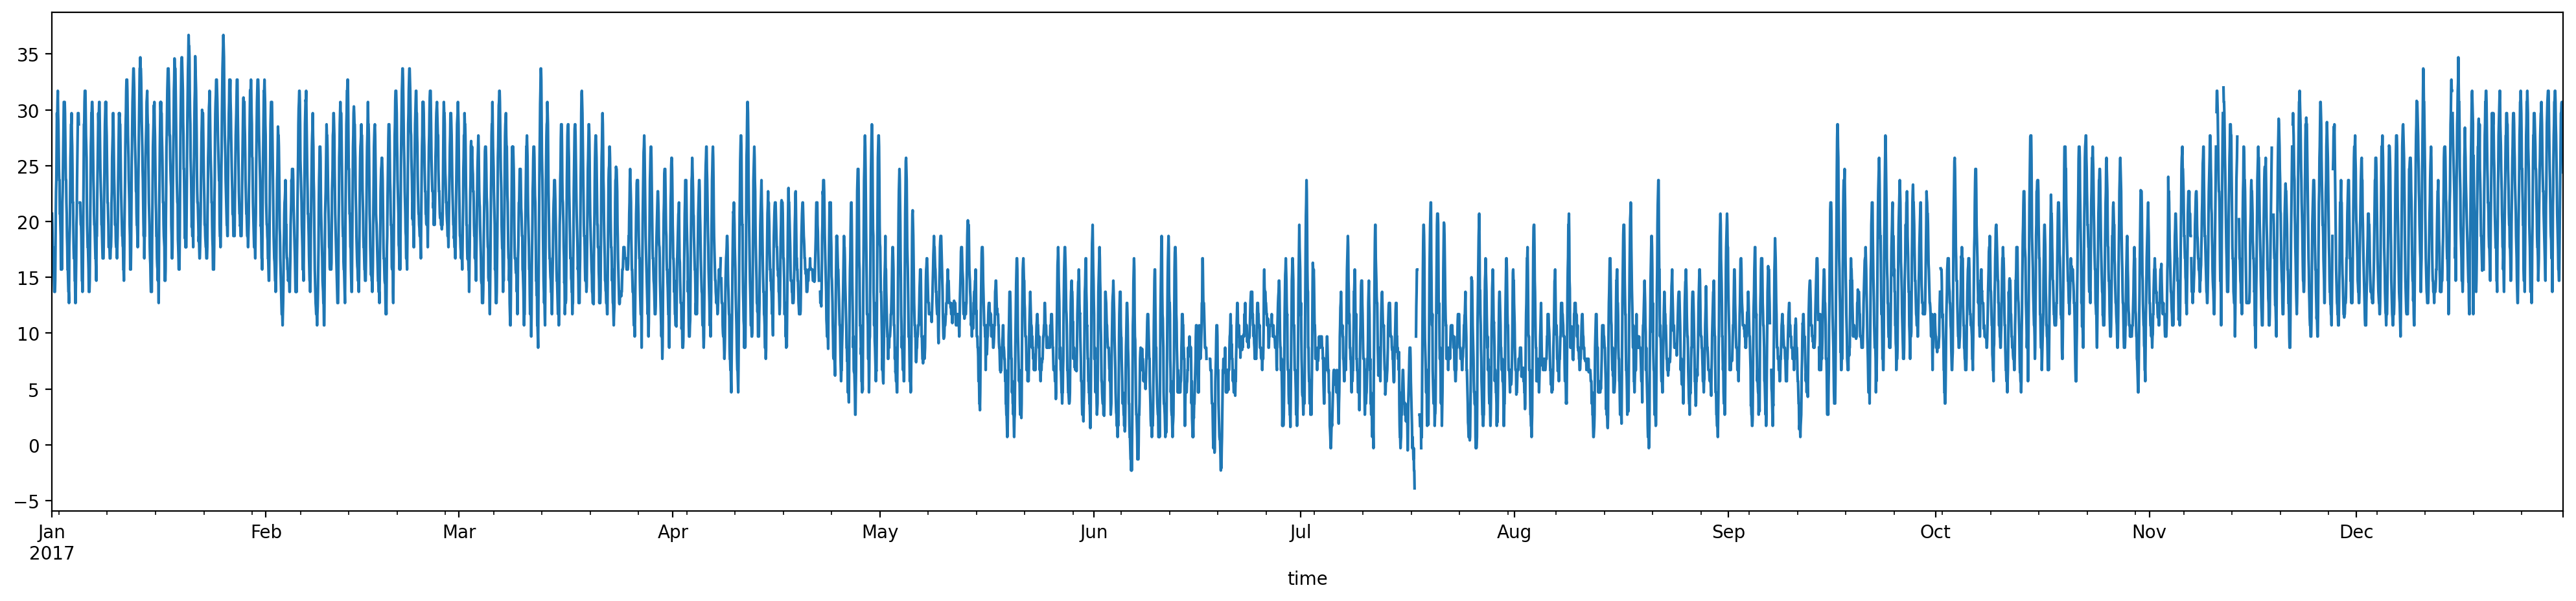

In [190]:
data.temp.plot(figsize=(25,5));

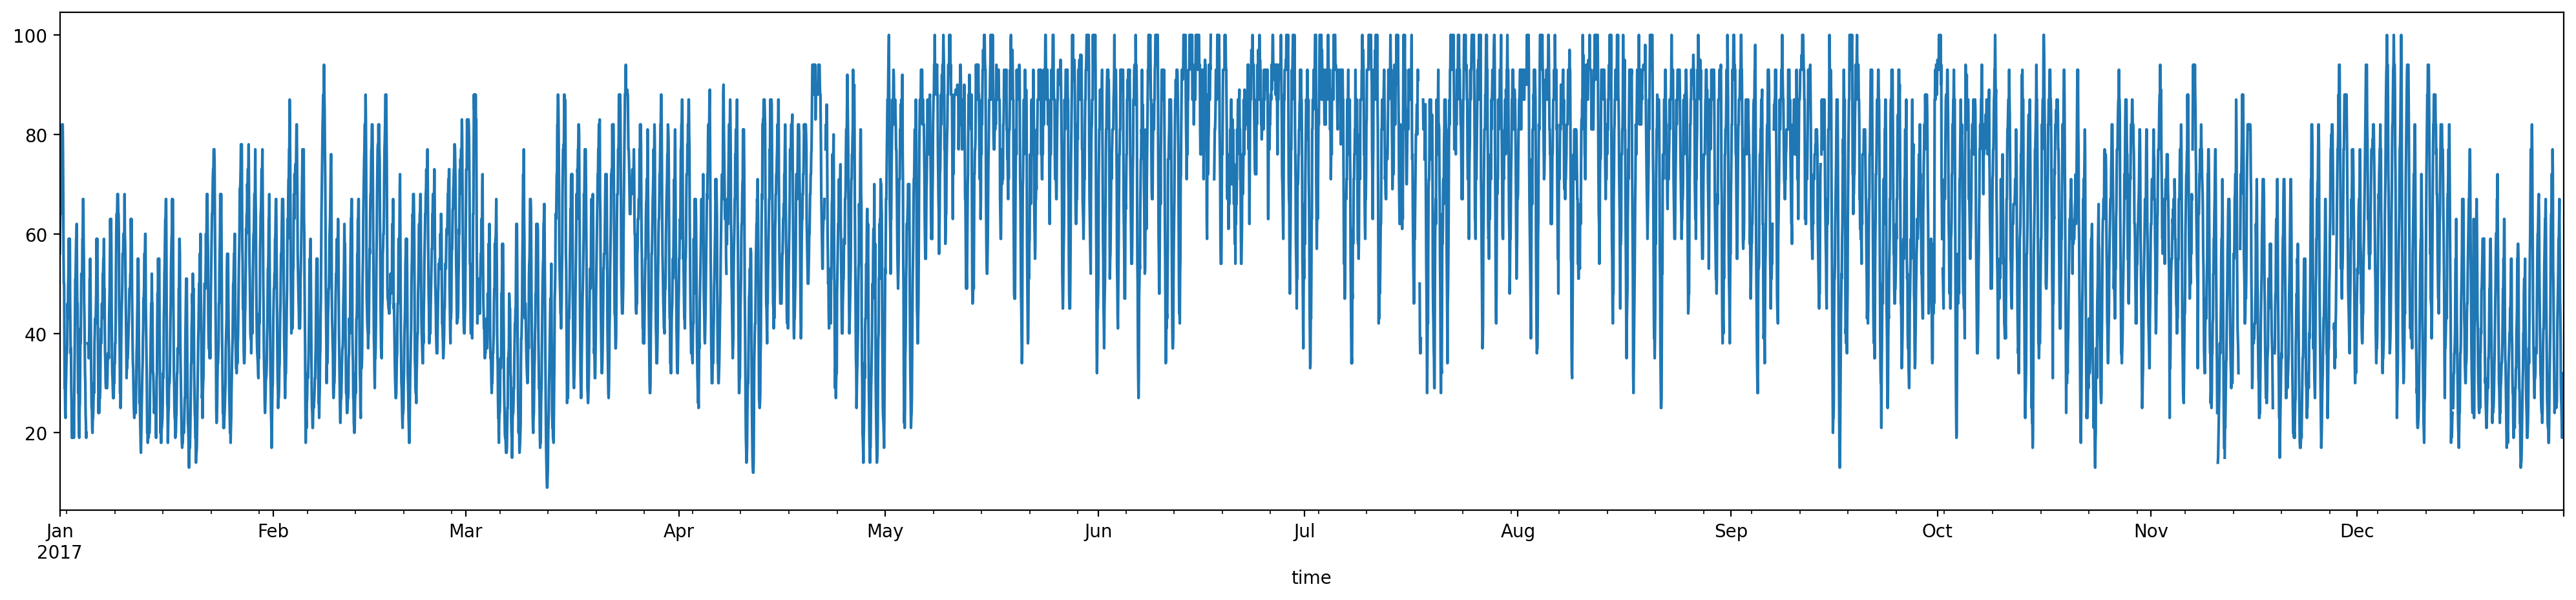

In [191]:
data.rhum.plot(figsize=(25,5));

In [15]:
data.columns

Index(['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'tsun'],
      dtype='object')

## Answers

### 1. How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?

For this i will do a simple exploratory data analysis

### 2. Generate the following additional columns. Please export them to a CSV file named synthetic_features.csv

In [354]:
synthetic_features = pd.DataFrame()

- high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.

In [355]:
range_season1 = ((df['Fecha-I'].dt.month == 12) & (df['Fecha-I'].dt.day >= 15)) | ((df['Fecha-I'].dt.month == 1) | (df['Fecha-I'].dt.month == 2) | ((df['Fecha-I'].dt.month == 3) & (df['Fecha-I'].dt.day <= 3)))
range_season2 = ((df['Fecha-I'].dt.month == 7) & (df['Fecha-I'].dt.day >= 15) & (df['Fecha-I'].dt.day <= 31))
range_season3 = ((df['Fecha-I'].dt.month == 9) & (df['Fecha-I'].dt.day >= 11) & (df['Fecha-I'].dt.day <= 30))

In [356]:
df.loc[range_season1 | range_season2 | range_season3,'high_season'] = 1 # high season
df.high_season = df.high_season.fillna(0) # low season

In [357]:
synthetic_features['high_season'] = df.high_season

- min_diff : difference in minutes between Date-O and Date-I

In [358]:
df['min_diff'] = (df['Fecha-O']-df['Fecha-I'])/timedelta(minutes=1)


In [359]:
synthetic_features['min_diff'] = df['min_diff']

In [360]:
df[['Fecha-I','Fecha-O','min_diff']].head()

,Fecha-I,Fecha-O,min_diff
0,2017-01-01 23:30:00,2017-01-01 23:33:00,3.0
1,2017-01-02 23:30:00,2017-01-02 23:39:00,9.0
2,2017-01-03 23:30:00,2017-01-03 23:39:00,9.0
3,2017-01-04 23:30:00,2017-01-04 23:33:00,3.0
4,2017-01-05 23:30:00,2017-01-05 23:28:00,-2.0


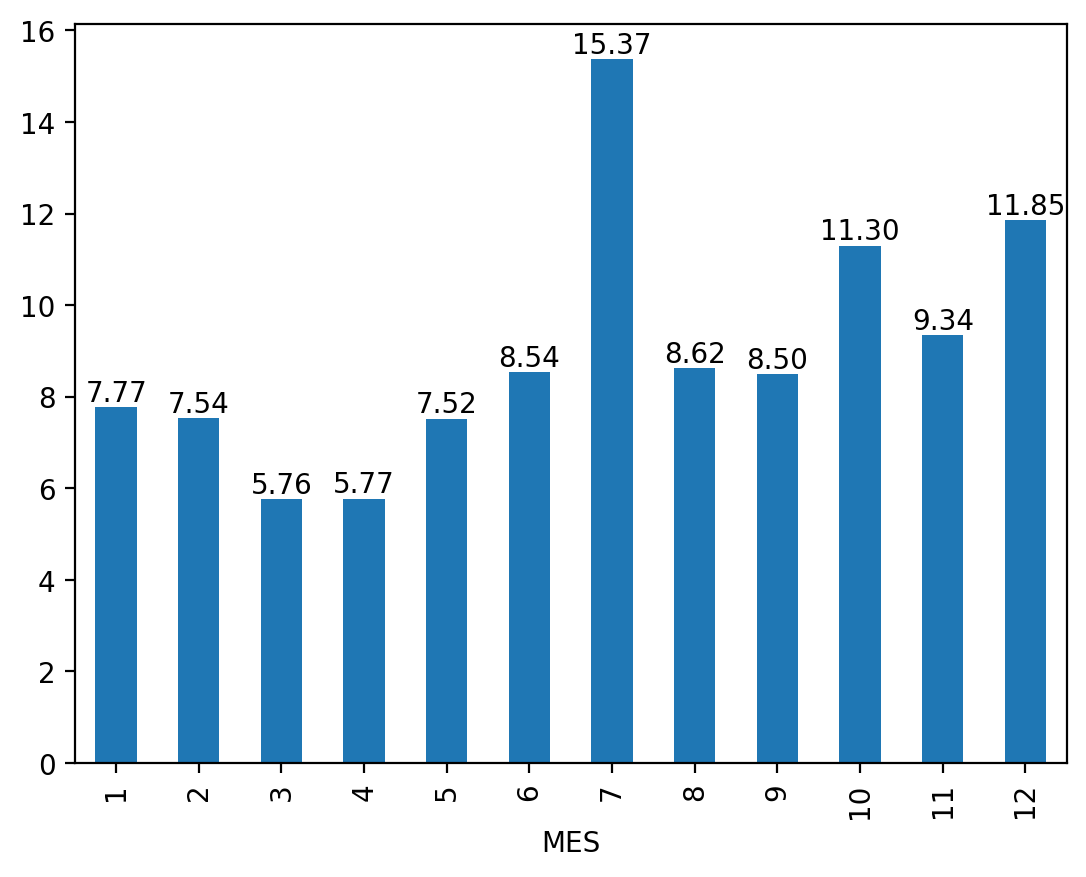

In [361]:
ax = df.groupby("MES")['min_diff'].mean().plot.bar();
ax.bar_label(ax.containers[0],fmt='%.2f');

weather data could be a good feature to predict the delay, because the delay is higher in the winter season


In [362]:
data.loc[:,'MES'] = data.index.month
data_daily.loc[:,'MES'] = data_daily.index.month

AttributeError: 'dict' object has no attribute 'index'

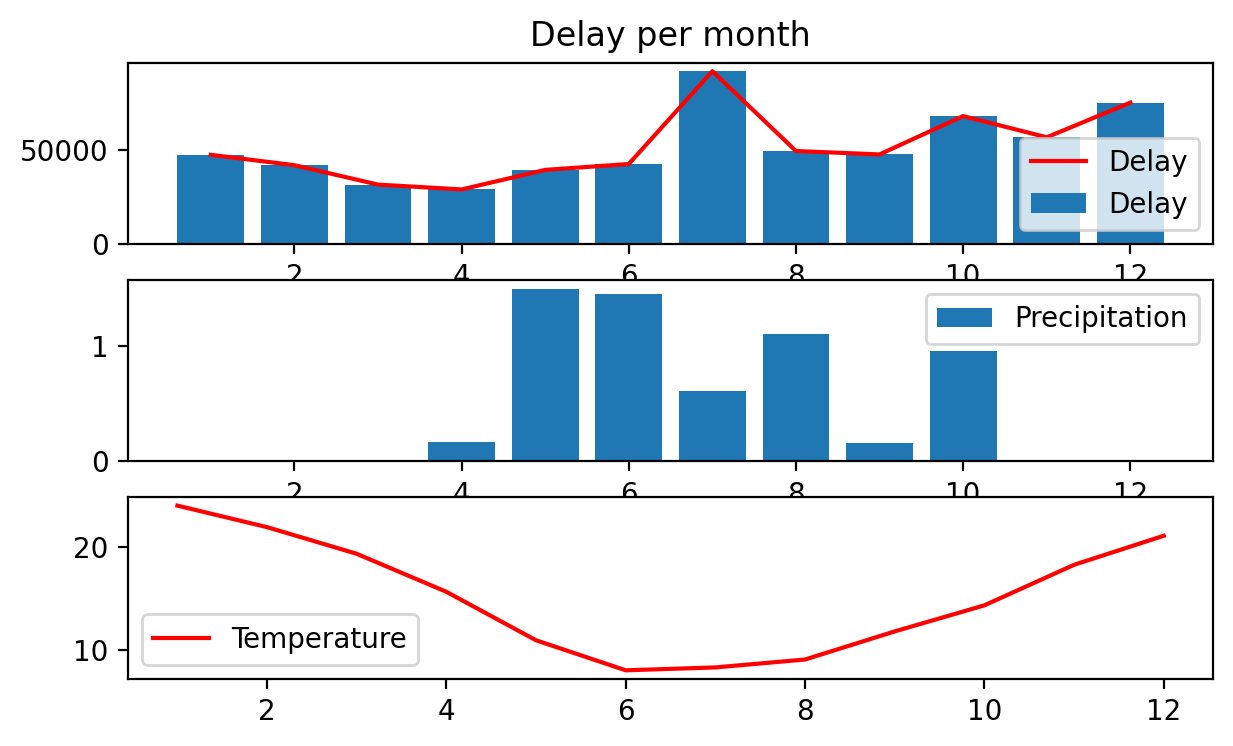

In [363]:
fig, axes = plt.subplots(3, 1, figsize=(7, 4))

axes[0].bar(df.groupby("MES")['min_diff'].sum().index, df.groupby("MES")['min_diff'].sum(), label = 'Delay')
axes[0].plot(df.groupby("MES")['min_diff'].sum().index, df.groupby("MES")['min_diff'].sum(), label = 'Delay' , c = 'r')
axes[1].bar(data_daily.groupby("MES")['prcp'].mean().index, data_daily.groupby("MES")['prcp'].mean() ,label = 'Precipitation')
axes[2].plot(data_daily.groupby("MES")['tavg'].mean().index, data_daily.groupby("MES")['tavg'].mean(), c = 'r', label = 'Temperature')

axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].set_title('Delay per month');

- delay_15 : 1 if min_diff > 15, 0 if not.

In [364]:
synthetic_features['delay_15'] = np.where(df['min_diff'].astype(float) > 15, 1, 0)
df['delay_15'] = np.where(df['min_diff'].astype(float) > 15, 1, 0)

In [365]:
synthetic_features.delay_15.value_counts()

0    55592
1    12614
Name: delay_15, dtype: int64

- period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based
onDate-I

In [366]:
df.loc[((df['Fecha-I'].dt.hour>=5 )& (df['Fecha-I'].dt.hour<12)),'period_day'] = 'morning'
df.loc[((df['Fecha-I'].dt.hour>=12 )& (df['Fecha-I'].dt.hour<19)),'period_day'] = 'afternoon'
df.loc[((df['Fecha-I'].dt.hour>=19 )| (df['Fecha-I'].dt.hour<5)),'period_day'] = 'night'

In [367]:
df.period_day.value_counts()

afternoon    25506
morning      25352
night        17348
Name: period_day, dtype: int64

In [368]:
synthetic_features['period_day'] = df.period_day

In [218]:
synthetic_features.to_csv('./synthetic_features.csv', index=False)

### 3. What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight?What variables would you expect to have the most influence in predicting delays?

In [281]:
df.SIGLADES.unique()

array(['Miami', 'Dallas', 'Buenos Aires', 'Toronto', 'Paris',
       'Ciudad de Mexico', 'Bogota', 'Roma', 'Londres',
       'Ciudad de Panama', 'Atlanta', 'Sao Paulo', 'Rio de Janeiro',
       'Florianapolis', 'Madrid', 'Lima', 'Sydney', 'Houston', 'Asuncion',
       'Cataratas Iguacu', 'Puerto Montt', 'Punta Arenas',
       'Puerto Natales', 'Balmaceda', 'Temuco', 'Valdivia', 'Concepcion',
       'La Serena', 'Copiapo', 'Calama', 'Antofagasta', 'Iquique',
       'Arica', 'Mendoza', 'Cordoba', 'Montevideo', 'Castro (Chiloe)',
       'Osorno', 'Orlando', 'Nueva York', 'Guayaquil', 'Cancun',
       'Punta Cana', 'Los Angeles', 'Auckland N.Z.', 'Isla de Pascua',
       'La Paz', 'Santa Cruz', 'Curitiba, Bra.', 'Quito', 'Bariloche',
       'Rosario', 'Washington', 'Tucuman', 'Melbourne', 'San Juan, Arg.',
       'Neuquen', 'Pisco, Peru', 'Ushuia', 'Puerto Stanley',
       'Punta del Este', 'Cochabamba'], dtype=object)

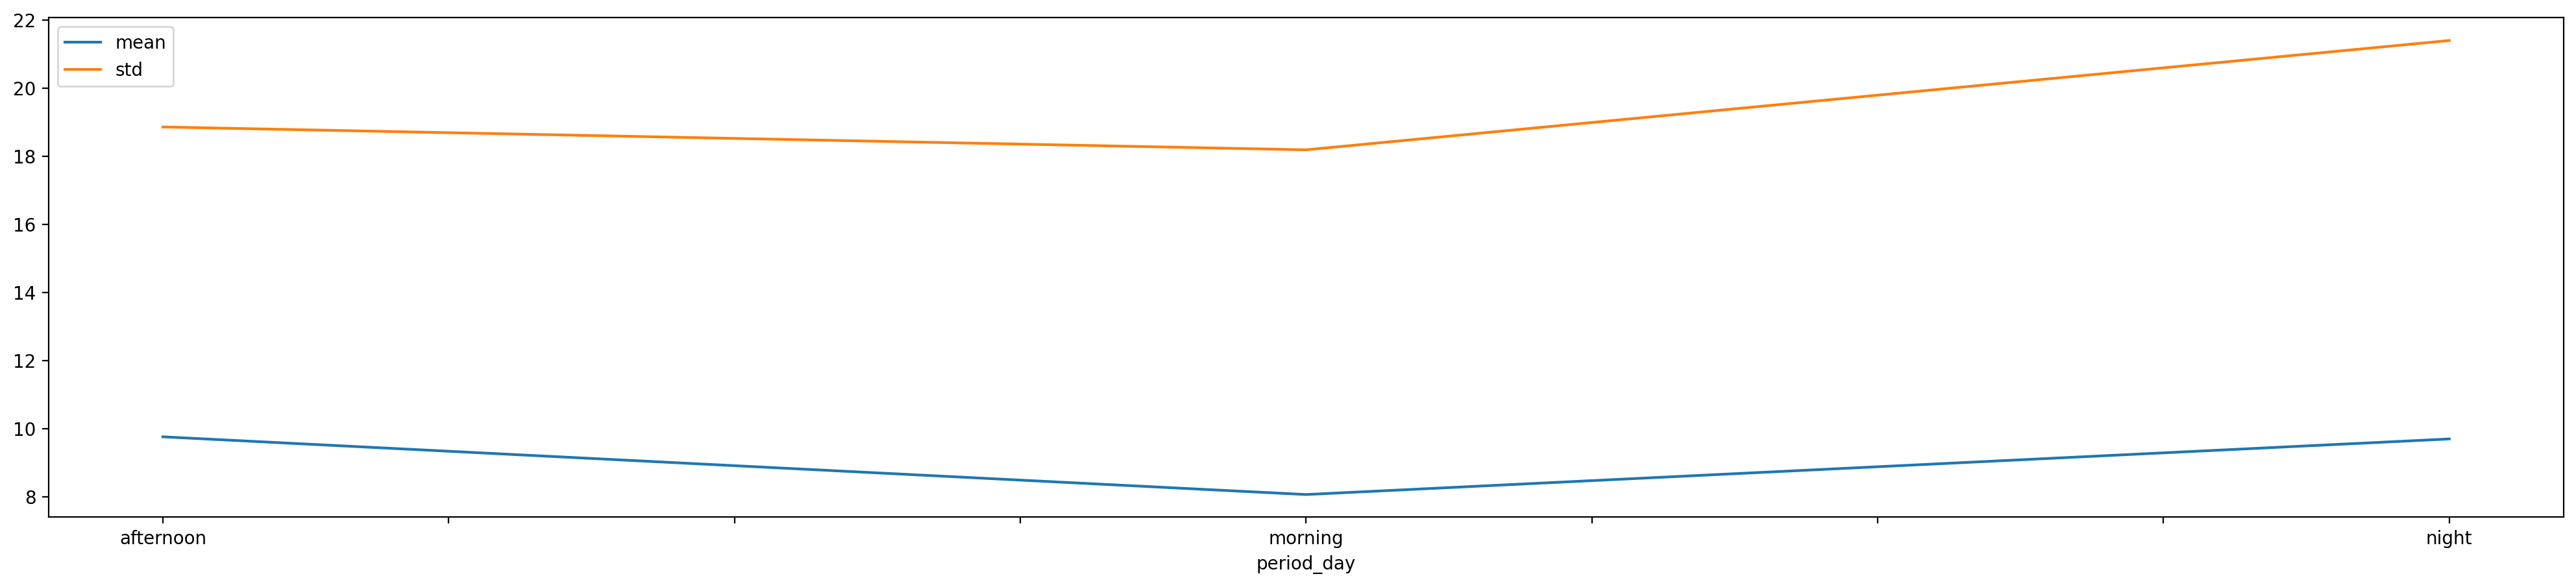

In [435]:
df.groupby(['period_day'])['min_diff'].agg(["mean","std"]).plot(figsize=(25,5));

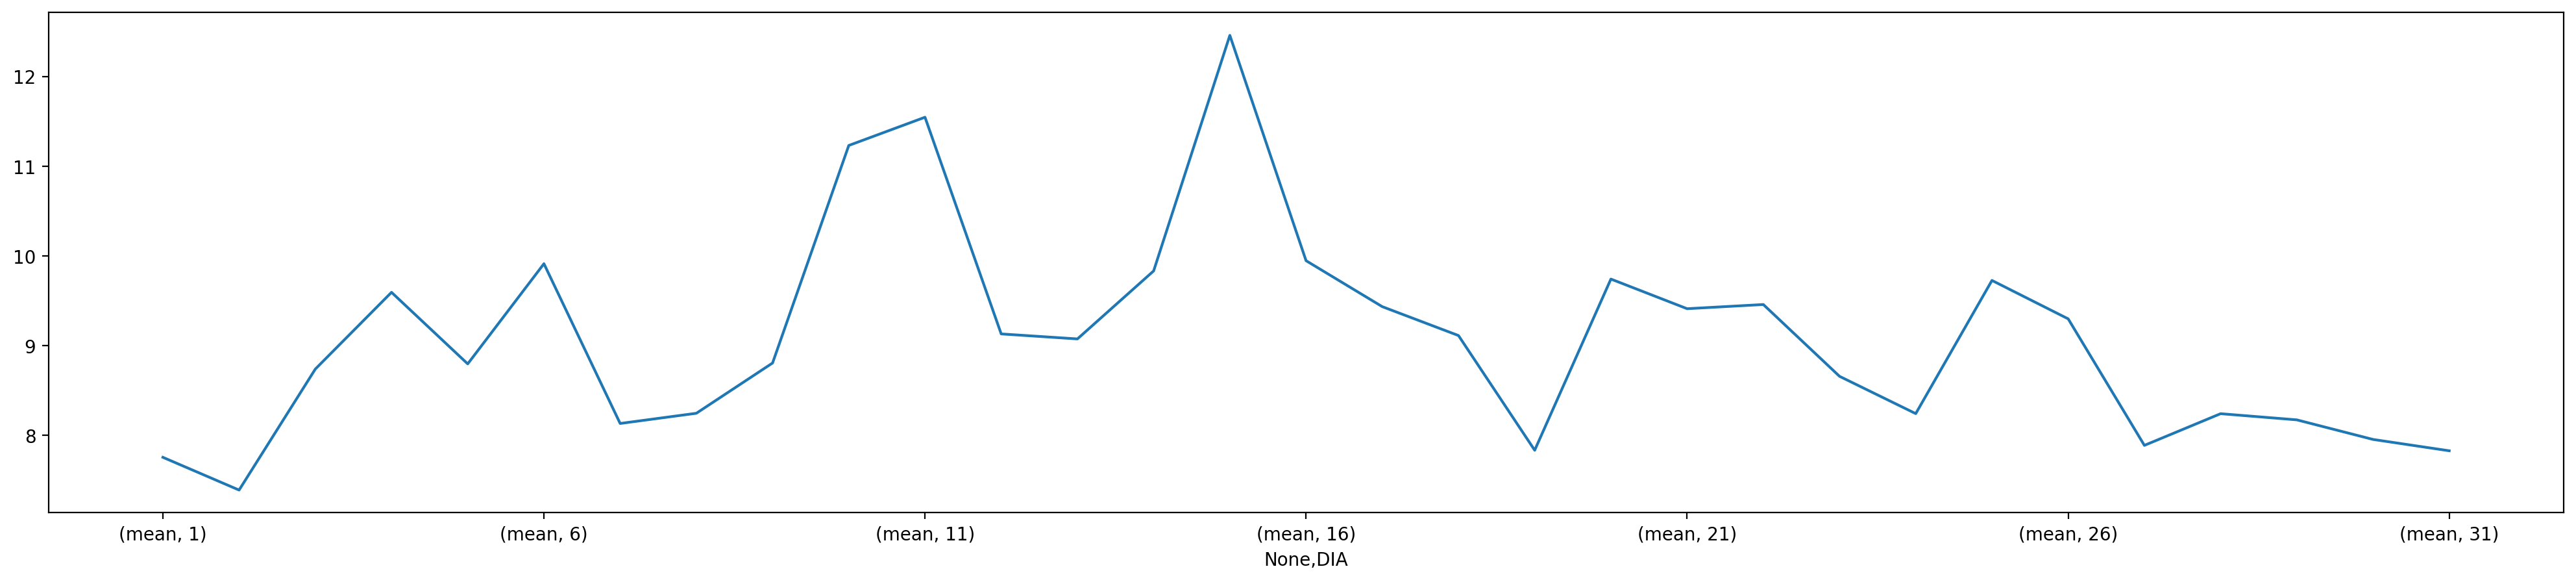

In [401]:
df.groupby(['DIA'])['min_diff'].agg(["mean"]).unstack(level=0).plot(figsize=(25,5));

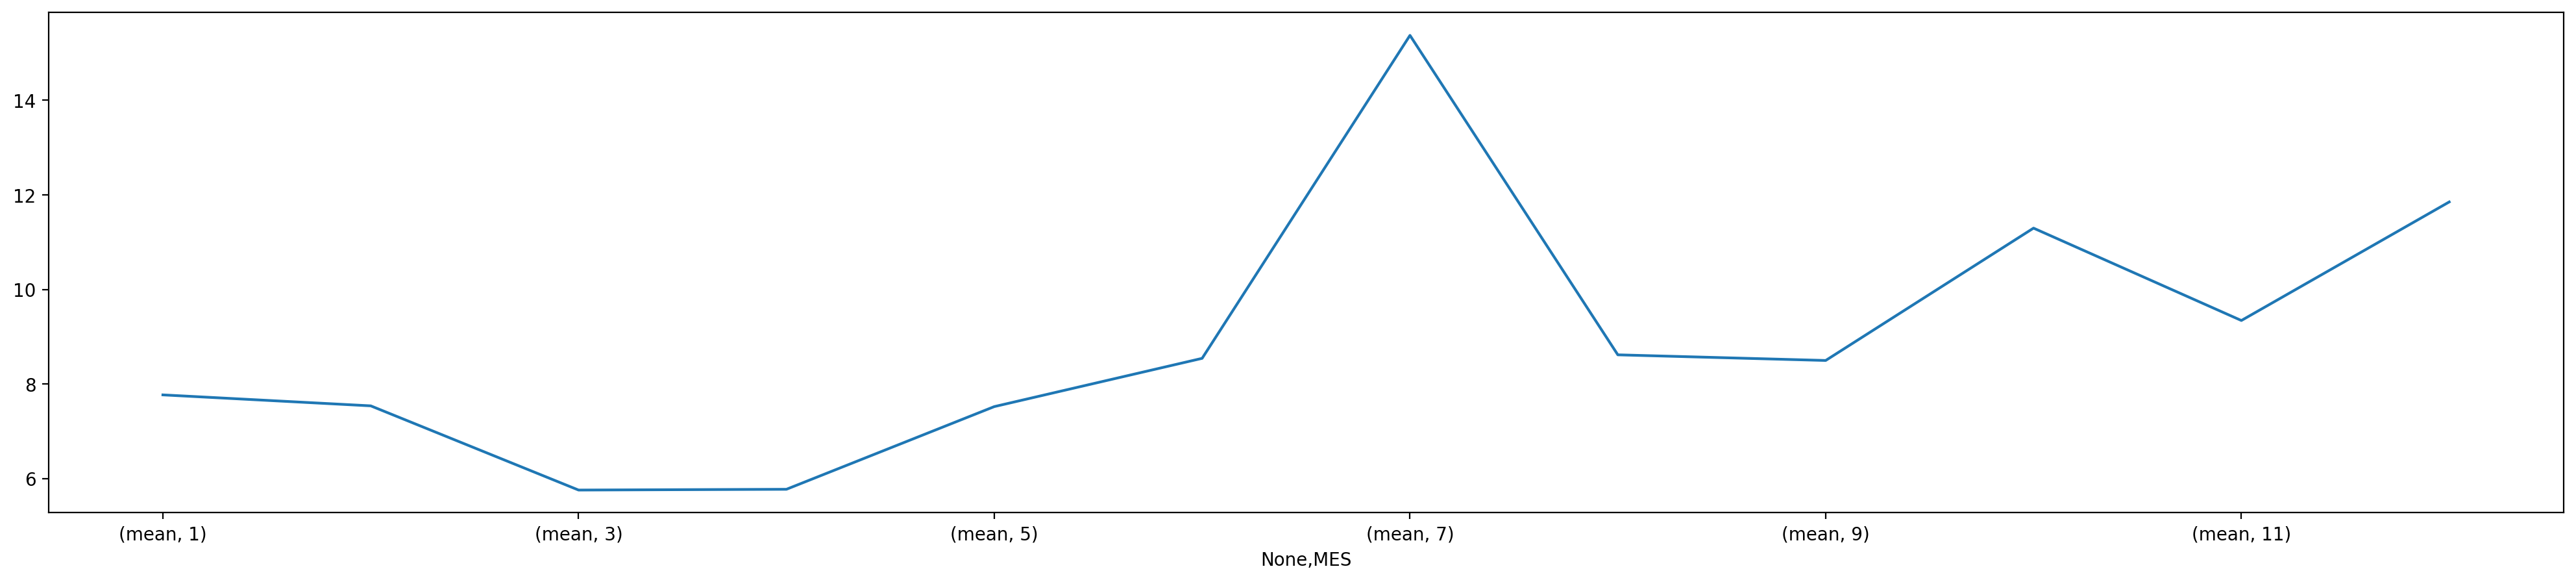

In [403]:
df.groupby(['MES'])['min_diff'].agg(["mean"]).unstack(level=0).plot(figsize=(25,5));

In [420]:
data_delay = df[df.min_diff>0]

<Axes: xlabel='DIANOM'>

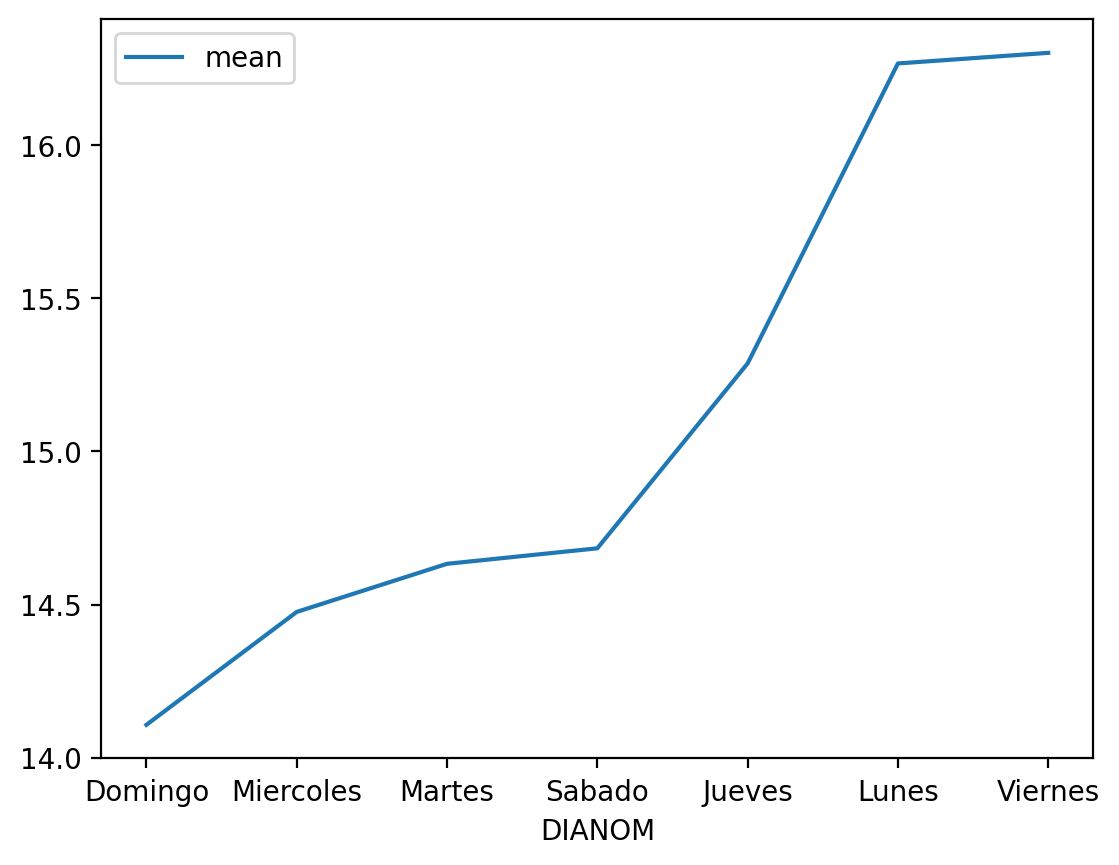

In [421]:
data_delay.groupby(['DIANOM'])['min_diff'].agg(["mean"]).sort_values(by='mean').plot()

<Axes: xlabel='MES'>

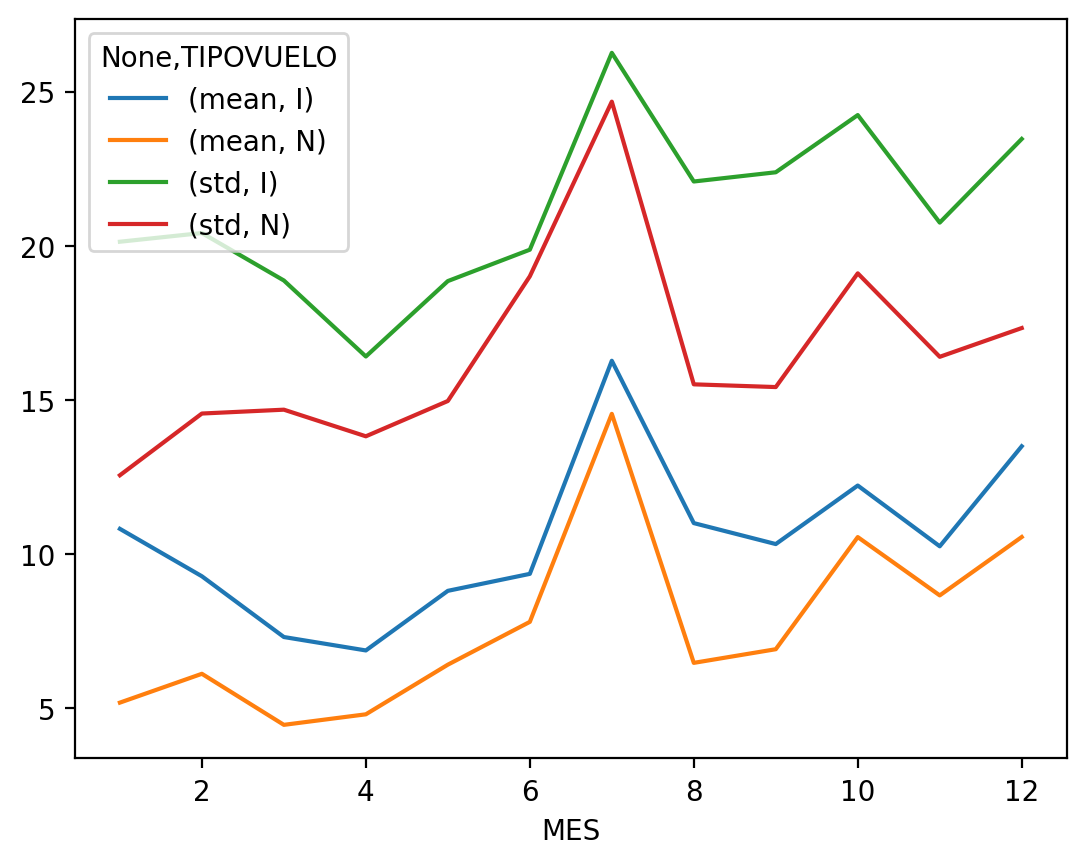

In [423]:
df.groupby(['TIPOVUELO','MES'])['min_diff'].agg(["mean","std"]).unstack(level=0).plot()

#### Anexos : Visualización

In [446]:
# read the shapefile of Chile's cities
chile_comunas = gpd.read_file('comunas.shp')
chile_regional = gpd.read_file('Regional.shp')

In [460]:
indices_destino = df[df.TIPOVUELO=='N'].groupby(['SIGLADES'])['min_diff'].agg(["mean"]).sort_values(by='mean').index

In [548]:
loc_nationals = df[df.TIPOVUELO=='N'].SIGLADES.unique().tolist()
loc_internationals = df[df.TIPOVUELO=='I'].SIGLADES.unique().tolist()

In [551]:
national = df[df.TIPOVUELO=='N'].groupby(['SIGLADES'])['min_diff'].agg(["mean"],as_index=False).sort_values(by='mean')

In [560]:
loc_nationals = ['Puerto Natales', 'Calama', 'Castro (Chiloe)', 'Antofagasta', 'Arica',
       'Copiapo', 'Valdivia', 'La Serena', 'Temuco', 'Concepción, Chile', 'Iquique',
       'Puerto Montt', 'Balmaceda', 'Punta Arenas', 'Osorno, Chile',
       'Isla de Pascua']

In [567]:
list_region_from_city = get_location(loc_nationals)

In [570]:
loc_regions = pd.DataFrame(list_region_from_city)[0].apply(lambda x: x.split(' ',1)[1:][0]).tolist()

In [572]:
national["region"] = loc_regions
national.iloc[0,1] = "Región de Magallanes y Antártica Chilena"
national.loc['Concepcion','region'] = 'Región del Bío-Bío'
national.loc['Temuco','region'] = 'Región de La Araucanía'

In [576]:
df = df.merge(national.reset_index()[['SIGLADES','region']], left_on='SIGLADES', right_on='SIGLADES', how='left')

In [ ]:
national = df.groupby('region',as_index=False)['min_diff'].mean()
merge = chile_regional.merge( national, left_on='Region', right_on='region', how='left')

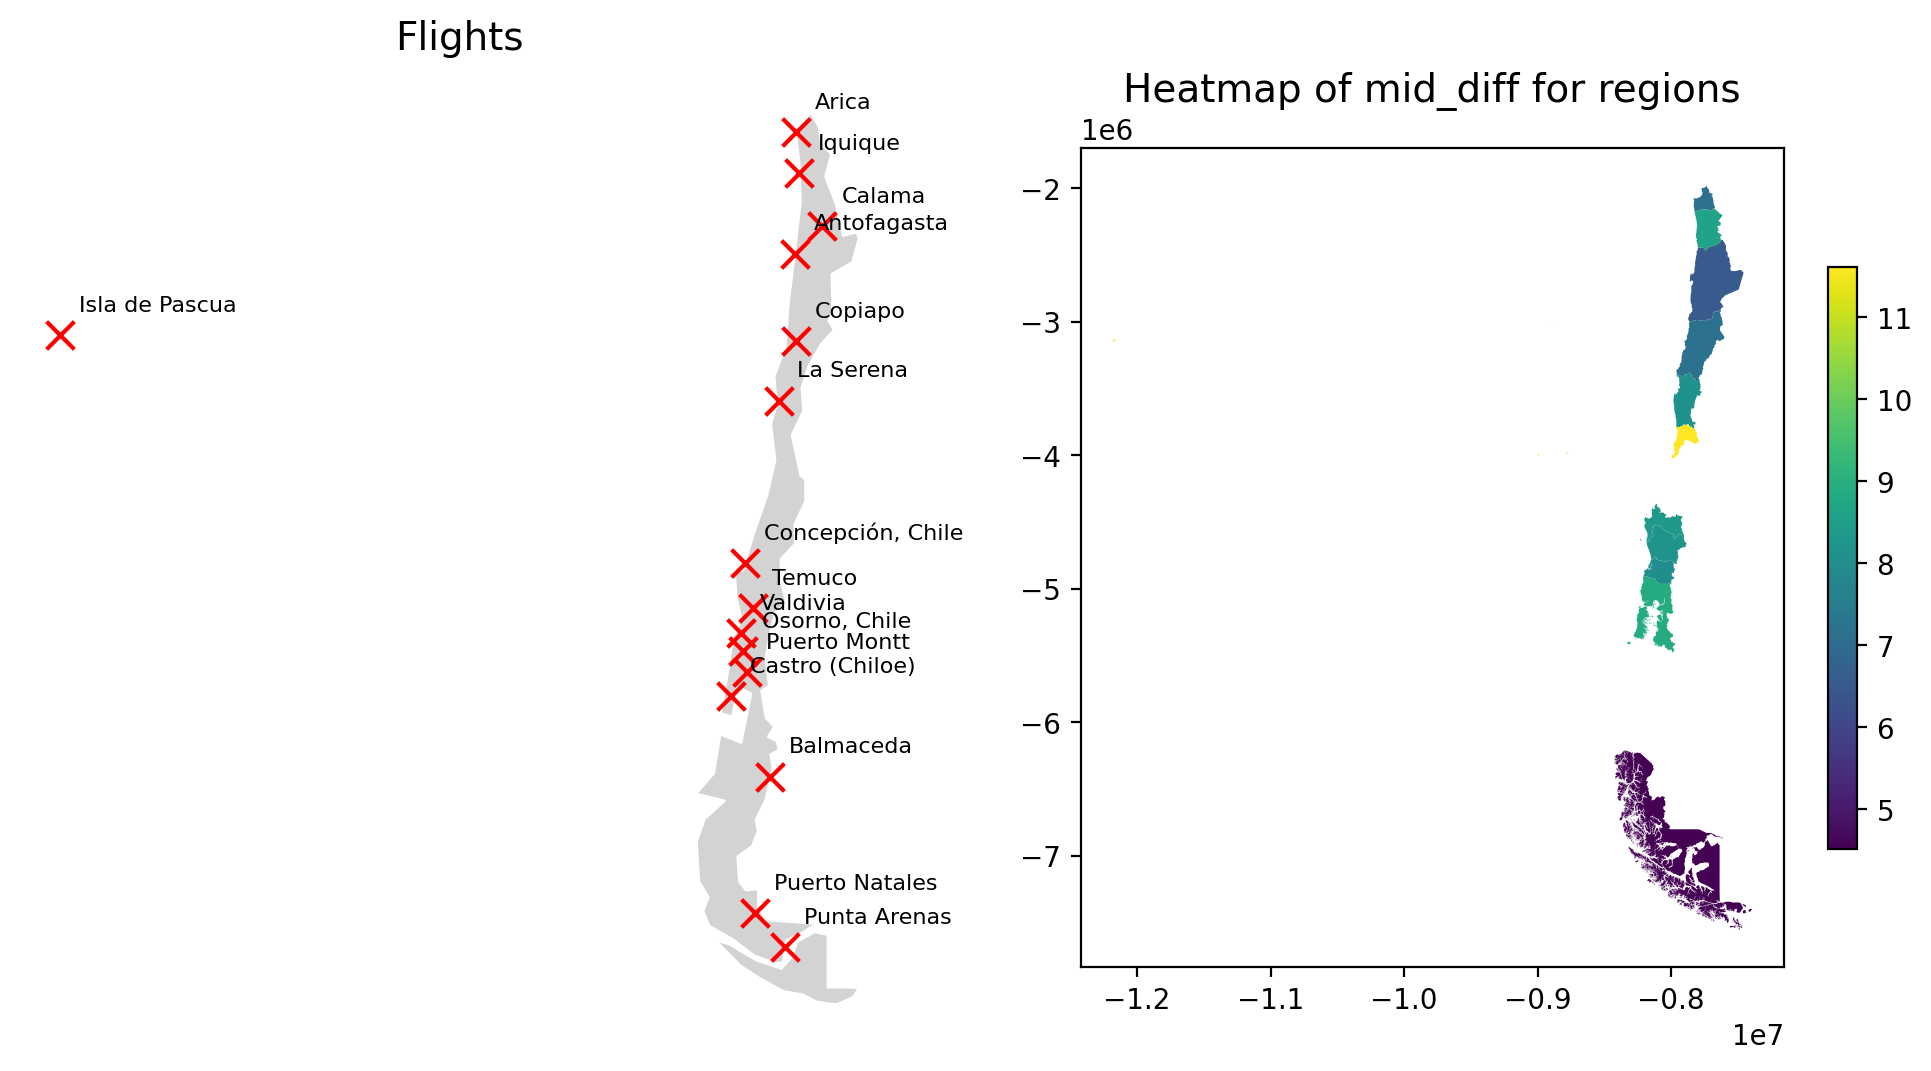

In [547]:
# Define the cities
cities = loc_nationals

# Geocode the cities to obtain their coordinates
geolocator = Nominatim(user_agent='my_app')
locations = [geolocator.geocode(city) for city in cities]
latitudes = [location.latitude for location in locations]
longitudes = [location.longitude for location in locations]

# Create a DataFrame with the city names and coordinates
data = {'City': cities, 'Latitude': latitudes, 'Longitude': longitudes}
df_ = pd.DataFrame(data)

# Read the world map dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Select only Chile
chile = world[world.name == 'Chile']

# Plot the cities on the world map
fig, ax = plt.subplots(1,2,figsize=(10, 10))

merge.plot(column='min_diff', ax=ax[1], legend=True, legend_kwds={'shrink': 0.3})
ax[1].set_title('Heatmap of mid_diff for regions', fontsize=14)

chile.plot(ax=ax[0], color='lightgray', edgecolor='white')
ax[0].scatter(df_['Longitude'], df_['Latitude'], color='red', marker='x', s=100)
for i, row in df_.iterrows():
    ax[0].text(row['Longitude'] + 1, row['Latitude'] + 1, row['City'], fontsize=8)
ax[0].set_title('Flights', fontsize=14)
ax[0].set_axis_off()
fig.tight_layout()
plt.show()
